In [1]:
from qiskit.circuit import Delay, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2

import sys
import os

sys.path.append(os.path.abspath("..\\..\\..\\.."))
from objects.shor_code_circuit import ShorCodeCircuit
from functions import *

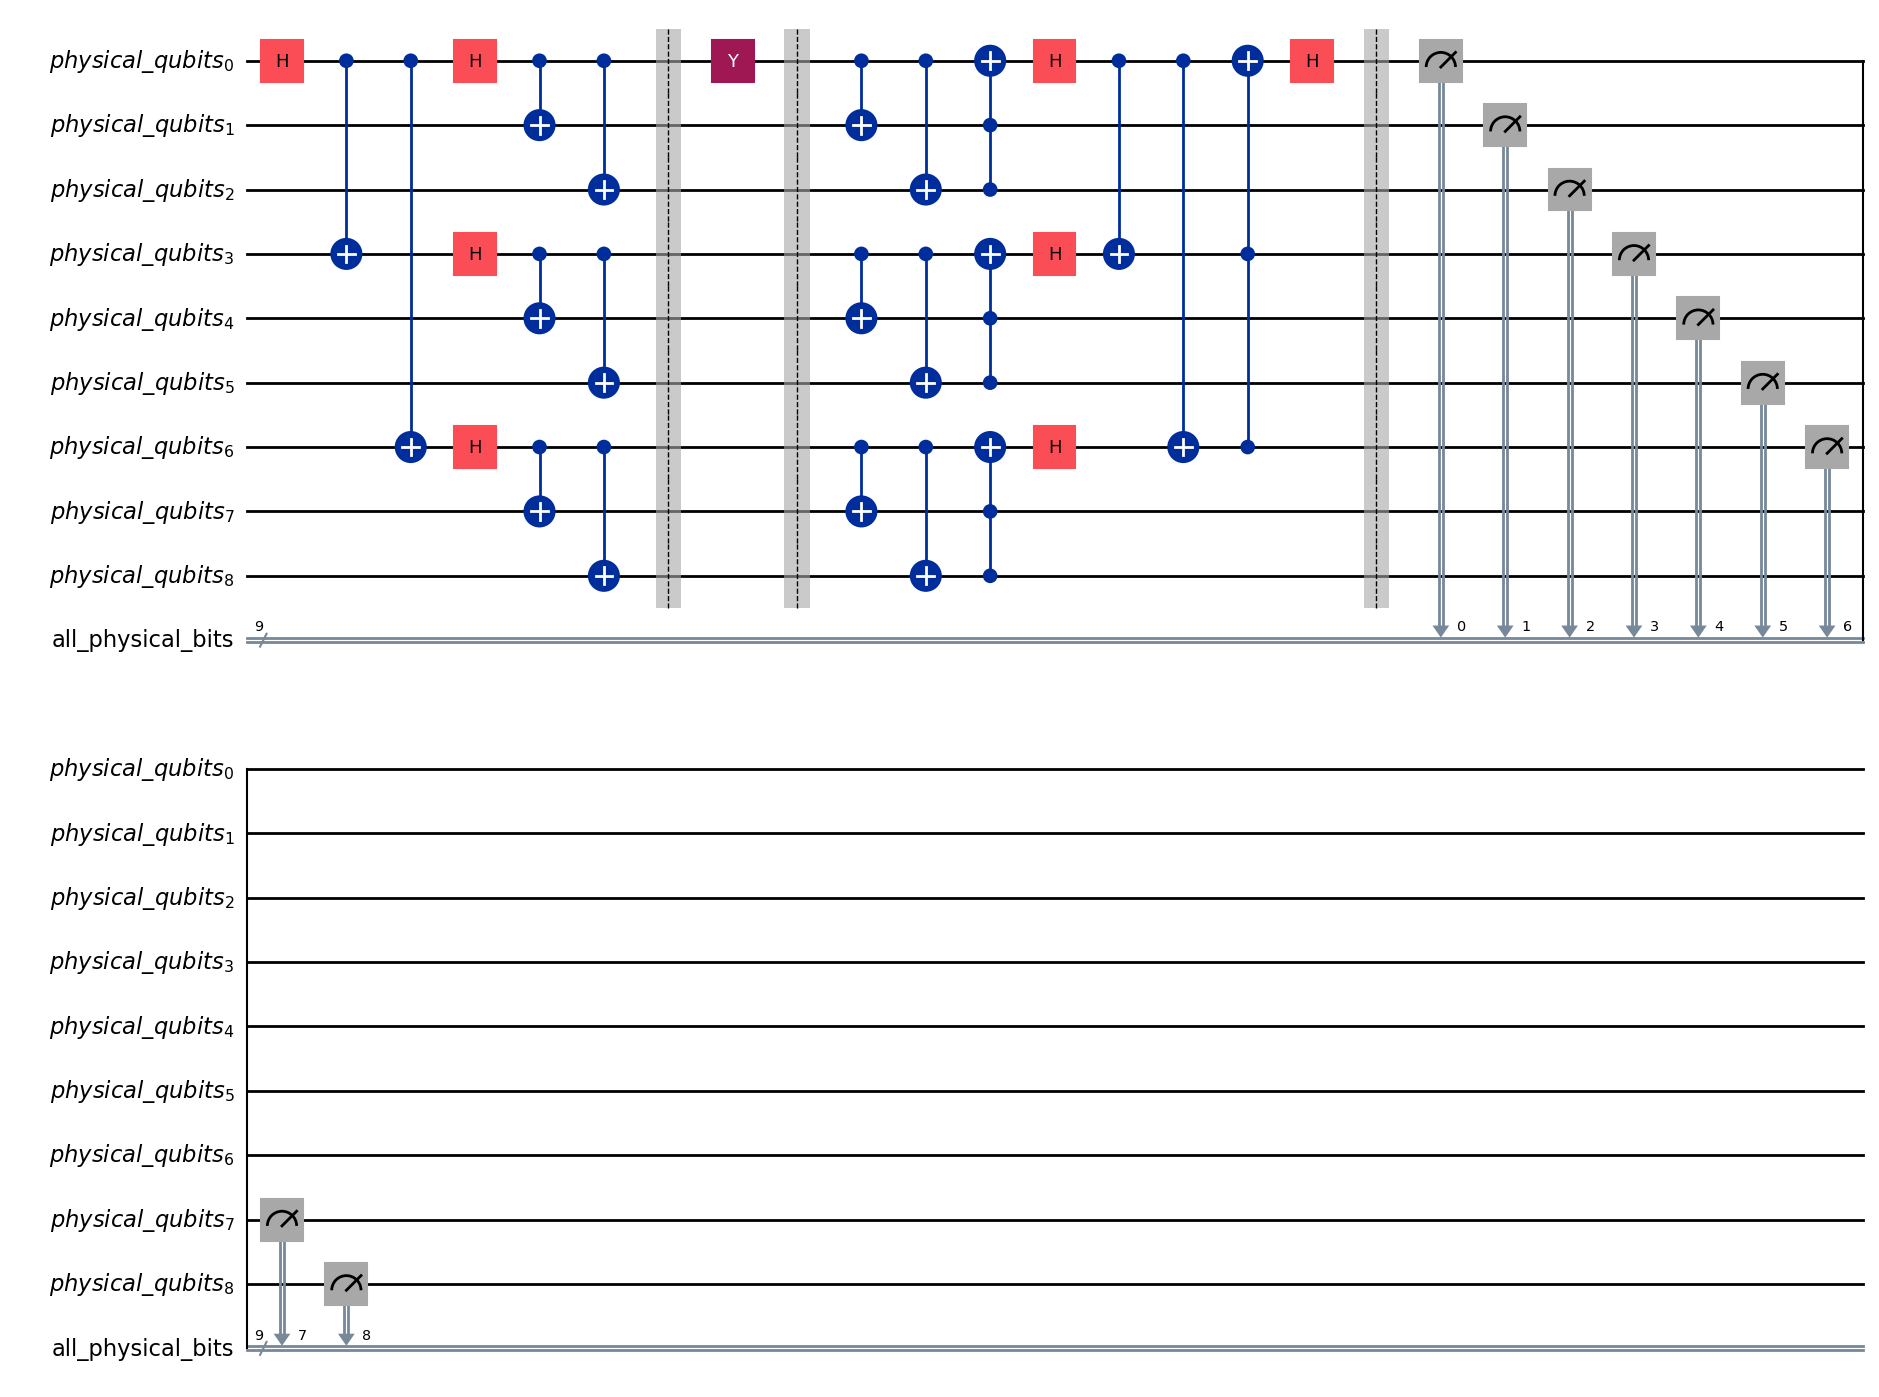

In [2]:
def load_circuit(initial_state='0', error = (None, None), measure='decoded_state', decoding=True, encoding='universal'):
    
    qc = ShorCodeCircuit(1)

    if initial_state == '1':
        qc.physical_quantum_circuit.x(0)
    elif initial_state == '+':
        qc.physical_quantum_circuit.h(0)
    elif initial_state == '-':
        qc.physical_quantum_circuit.x(0)
        qc.physical_quantum_circuit.h(0)
    else:
        pass

    if encoding == 'universal':
        qc.encode()
    elif encoding == 'particular':
        qc.encode(initial_state='0')

    qc.barrier()

    if error:
        position = error[1]
        match error[0]:
            case 'X':
                qc.physical_quantum_circuit.x(position)
            case 'Y':
                qc.physical_quantum_circuit.y(position)
            case 'Z':
                qc.physical_quantum_circuit.z(position)

    qc.barrier()

    if decoding:
        qc.decode()

        if initial_state in ['+', '-']:
            qc.physical_quantum_circuit.h(0)

        qc.barrier()

    match measure:
        case 'decoded_state':
            circuit = qc.physical_quantum_circuit
            creg = ClassicalRegister(1, 'c')
            circuit.add_register(creg)
            circuit.measure(circuit.qubits[0], creg)
        case 'all':
            qc.measure_all(basis='all')

    return qc


qc = load_circuit(initial_state='+', error=('Y',0),
                   measure='all',
                #    encoding='particular'
                #    decoding=False
                   )
qc.draw_physical_circuit('mpl')

In [22]:
# for state in ['0', '1', '+', '-']:
#     print(f"Initial State: {state}\n")

#     for error_type in ['X', 'Y', 'Z']:
#         for error_position in range(9):

#             qc = load_circuit(initial_state=state, error=(error_type, error_position), measure='all')
#             final_state = list(extract_simulation_results(
#                 sampler_simulation(qc.physical_quantum_circuit, 10), omit_zeros=True
#                 )['all_physical_bits'][0].keys())[0]
            
#             # print('\t\t\t', extract_simulation_results(
#             #     sampler_simulation(qc.physical_quantum_circuit, 100), omit_zeros=True
#             #     )['all_physical_bits'][0])


#             print(f"\tError: {error_type}{error_position} | Final State: {final_state}")
#         print('')

            


In [56]:
# matrix = [
#     "00100100",
#     "00100100",
#     "00100100",
#     "00100000",
#     "00100000",
#     "00100000",
#     "00000100",
#     "00000100",
#     "00000100",

#     "11000000",
#     "10000000",
#     "01000000",
#     "00011000",
#     "00010000",
#     "00001000",
#     "00000011",
#     "00000010",
#     "00000001",
# ]

# transposed_matrix = [
#     ''.join([row[i] for row in matrix])
#     for i in range(8)
# ]

# print(*transposed_matrix, sep='\n')

In [3]:
ibm_token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token)
backend = service.backend("ibm_sherbrooke")

In [11]:
phy_qc = qc.physical_quantum_circuit
print(f"Circuit Depth: {qc.physical_quantum_circuit.depth()}")

Circuit Depth: 16


In [12]:
isa_circuit = get_transpile(phy_qc, backend, iterations=100)
print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")
print(get_layout(isa_circuit, 9))

Transpiled Circuit Depth: 99
[118, 110, 119, 117, 120, 100, 116, 101, 121]


In [13]:
simulation_result = sampler_simulation(qc.physical_quantum_circuit, 500)

extract_simulation_results(simulation_result, omit_zeros=True)

{'all_physical_bits': [{'011100100': 500}]}

In [ ]:
sampler = SamplerV2(backend=backend)
shots = 2000
# job = sampler.run([isa_circuit], shots=shots)

# job = service.job('cz5qg0g1xvhg008eexz0') # state 1, decoding, error Y0, measure_all, 2000 shots -> {(True, True): 22.85, (True, False): 45.6, (False, True): 2.4, (False, False): 29.15}
# job = service.job('cz6c9mykvm9g008gjxt0') # state 0 (particular), decoding, error Y0, 2000 shots -> {(True, True): 28.95, (True, False): 45.9, (False, True): 0.95, (False, False): 24.2}
job = service.job('cz6dn24h0kc00089919g') # state +, decoding, error Y0, measure_all, 2000 shots -> {(True, True): 8.8, (True, False): 50.3, (False, True): 1.15, (False, False): 39.75}


pub_result = job.result()

In [33]:
ids = [ 'cz6c9mykvm9g008gjxt0', 'cz5qg0g1xvhg008eexz0', 'cz6dn24h0kc00089919g']
for state in ['0', '1', '+']:
    for error in ['Y0']:
        pub_result = service.job(ids.pop(0)).result()

        results = extract_results_IBM(pub_result, type='percentage')['all_physical_bits'][0]
        
        print(f"state {state}, error {error}")

        final_state = '1' if state == '1' else '0'
        
        st_syn_results = {
        (st, syn) : round(sum([
                results[state]
                for state in results
                if (state[1:] == '11100100') == syn
                and (state[:1] == final_state) == st
            ]), 2)
            for st in [True, False] for syn in [True, False]
        }

        print(f"dec state | syndrome | counts (%)")
        print(*st_syn_results.items(), sep='\n')
        print('Correction accuracy:', round(sum([st_syn_results[k] for k in st_syn_results if k[0]]),2), '%')
        print('\n')

state 0, error Y0
dec state | syndrome | counts (%)
((True, True), 28.95)
((True, False), 45.9)
((False, True), 0.95)
((False, False), 24.2)
Correction accuracy: 74.85 %


state 1, error Y0
dec state | syndrome | counts (%)
((True, True), 22.85)
((True, False), 45.6)
((False, True), 2.4)
((False, False), 29.15)
Correction accuracy: 68.45 %


state +, error Y0
dec state | syndrome | counts (%)
((True, True), 8.8)
((True, False), 50.3)
((False, True), 1.15)
((False, False), 39.75)
Correction accuracy: 59.1 %




In [24]:
results = extract_results_IBM(pub_result, type='percentage')['all_physical_bits'][0]
print(results)

{'000000000': 0.15, '000000001': 0.2, '000000010': 0.0, '000000011': 0.1, '000000100': 0.15, '000000101': 0.05, '000000110': 0.15, '000000111': 0.05, '000001000': 0.15, '000001001': 0.05, '000001010': 0.0, '000001011': 0.0, '000001100': 0.1, '000001101': 0.0, '000001110': 0.05, '000001111': 0.0, '000010000': 0.1, '000010001': 0.0, '000010010': 0.0, '000010011': 0.1, '000010100': 0.05, '000010101': 0.0, '000010110': 0.05, '000010111': 0.0, '000011000': 0.0, '000011001': 0.0, '000011010': 0.0, '000011011': 0.0, '000011100': 0.05, '000011101': 0.0, '000011110': 0.0, '000011111': 0.0, '000100000': 0.15, '000100001': 0.2, '000100010': 0.05, '000100011': 0.0, '000100100': 0.3, '000100101': 0.15, '000100110': 0.25, '000100111': 0.05, '000101000': 0.05, '000101001': 0.2, '000101010': 0.0, '000101011': 0.0, '000101100': 0.0, '000101101': 0.0, '000101110': 0.0, '000101111': 0.0, '000110000': 0.0, '000110001': 0.0, '000110010': 0.0, '000110011': 0.0, '000110100': 0.05, '000110101': 0.0, '00011011

In [25]:
states = get_possible_states(9)
valid_states = ['011100100'] # Y0

# plot_results_hamming_distance(results, 9, valid_states, omit_zeros=True)

In [26]:
print_order_results(results, valid_states, limit=10)

state: result, HD, error positions
011100100: 8.8%, 0, [[]]
011000100: 5.05%, 1, [[3]]
101100100: 3.85%, 2, [[0, 1]]
011100101: 3.75%, 1, [[8]]
011000101: 2.85%, 2, [[3, 8]]
011101100: 2.65%, 1, [[5]]
101000100: 2.3%, 3, [[0, 1, 3]]
011110100: 2.1%, 1, [[4]]
011001100: 1.6%, 2, [[3, 5]]
111000100: 1.45%, 2, [[0, 3]]


Final Decoded State

In [27]:
similarity = sum([
    results[state]
    for state in results
    if state[0] == '0'
])
print('Similarity:', similarity,'%')

Similarity: 59.1 %


Syndromes

In [28]:
syn_states = get_possible_states(8)
syn_valid_states = [v[1:] for v in valid_states]

In [29]:
syn_results = {
    syn : sum([
        results[state]
        for state in results
        if state[1:] == syn
    ])
    for syn in syn_states
}


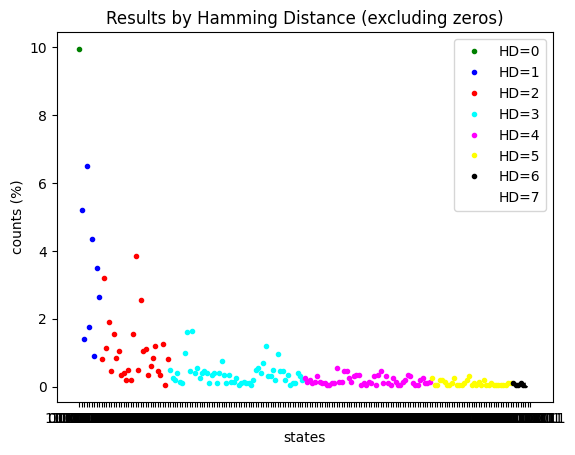

In [30]:
plot_results_hamming_distance(syn_results, 8, syn_valid_states, omit_zeros=True)

Decoded State and Syndrome all together

In [31]:
st_syn_results = {
    (st, syn) : sum([
        results[state]
        for state in results
        if (state[1:] in syn_valid_states) == syn
        and (state[:1] == '0') == st
    ])
    for st in [True, False] for syn in [True, False]
}

print(st_syn_results)

{(True, True): 8.799999999999999, (True, False): 50.3, (False, True): 1.15, (False, False): 39.75}


## Possible Errors and Syndromes analysis

In [13]:


for error_type in ['X', 'Y', 'Z']:
    for error_position in range(9):
        print(f"Error: {error_type}{error_position}\n")

        for state in ['0', '1', '+', '-']:

            qc = load_circuit(initial_state=state, error=(error_type, error_position), measure='all')
            final_state = list(extract_simulation_results(
                sampler_simulation(qc.physical_quantum_circuit, 10), omit_zeros=True
                )['all_physical_bits'][0].keys())[0]


            print(f"\tInput: {state} | Output: {final_state}")
        print('')

Error: X0

	Input: 0 | Output: 011000000
	Input: 1 | Output: 111000000
	Input: + | Output: 011000000
	Input: - | Output: 111000000

Error: X1

	Input: 0 | Output: 010000000
	Input: 1 | Output: 110000000
	Input: + | Output: 010000000
	Input: - | Output: 110000000

Error: X2

	Input: 0 | Output: 001000000
	Input: 1 | Output: 101000000
	Input: + | Output: 001000000
	Input: - | Output: 101000000

Error: X3

	Input: 0 | Output: 000011000
	Input: 1 | Output: 100011000
	Input: + | Output: 000011000
	Input: - | Output: 100011000

Error: X4

	Input: 0 | Output: 000010000
	Input: 1 | Output: 100010000
	Input: + | Output: 000010000
	Input: - | Output: 100010000

Error: X5

	Input: 0 | Output: 000001000
	Input: 1 | Output: 100001000
	Input: + | Output: 000001000
	Input: - | Output: 100001000

Error: X6

	Input: 0 | Output: 000000011
	Input: 1 | Output: 100000011
	Input: + | Output: 000000011
	Input: - | Output: 100000011

Error: X7

	Input: 0 | Output: 000000010
	Input: 1 | Output: 100000010
	Inpu

In [14]:
def final_state(error, decoding=True):
    qc = load_circuit(initial_state='0', error=error, measure='all', decoding=decoding)
    return list(extract_simulation_results(
                sampler_simulation(qc.physical_quantum_circuit, 1), omit_zeros=True
                )['all_physical_bits'][0].keys())[0]

for error_type in ['X', 'Z']:
    for error_position in range(9):
        
        # non_dec_state = final_state((error_type, error_position), decoding=False)
        dec_state = final_state((error_type, error_position))

        print(f"Error: {error_type}{error_position} | Dec Syn: {dec_state[1:]}")
        # print(f"\"{dec_state[1:]}\",")
        #  | Corrected State: {dec_state[:1]}

    print('')

Error: X0 | Dec Syn: 11000000
Error: X1 | Dec Syn: 10000000
Error: X2 | Dec Syn: 01000000
Error: X3 | Dec Syn: 00011000
Error: X4 | Dec Syn: 00010000
Error: X5 | Dec Syn: 00001000
Error: X6 | Dec Syn: 00000011
Error: X7 | Dec Syn: 00000010
Error: X8 | Dec Syn: 00000001

Error: Z0 | Dec Syn: 00100100
Error: Z1 | Dec Syn: 00100100
Error: Z2 | Dec Syn: 00100100
Error: Z3 | Dec Syn: 00100000
Error: Z4 | Dec Syn: 00100000
Error: Z5 | Dec Syn: 00100000
Error: Z6 | Dec Syn: 00000100
Error: Z7 | Dec Syn: 00000100
Error: Z8 | Dec Syn: 00000100

